In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.ae_eval_and_vis import *
#from utils.ae_torch_classes import *
from utils.ae_V2_dropout import *

# Load in Data

In [2]:
from utils.data_loading_paths import *

kai_laptop = True
brc_desktop = False

if kai_laptop:
    data_path = kai_data_path
    model_dir_path = kai_model_dir_path
    metadata_path = kai_metadata_path
elif brc_desktop:
    data_path = brc_data_path
    model_dir_path = brc_model_dir_path
    metadata_path = brc_metadata_path

metadata_cols_df = pd.read_pickle(metadata_path)

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

In [3]:
print(training_u_df.shape)
training_u_df.head()

(160000, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.551109,-0.738972,-0.985439,0.181924,0.059616,0.087024,1.055804,-0.883268,-0.327978,-0.221822,...,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.571115,-0.821726,-0.975036,0.242607,0.067375,-0.024900,1.007074,-0.944195,-0.363602,-0.149833,...,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.509305,-0.823575,-0.947221,0.550111,0.013848,-0.485765,0.993332,-0.944029,-0.357476,-0.164447,...,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.511788,-0.775810,-0.947939,0.417919,0.087222,-0.229441,1.026003,-0.911993,-0.335594,-0.006214,...,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.441369,-0.921726,-0.882652,1.254970,0.108993,-0.933639,1.001748,-0.939228,-0.357917,0.009543,...,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [4]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Create the dataset
u_training_dataset = GestureDatasetAE(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDatasetAE(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

# RNN Autoencoder

In [5]:
# Example usage
input_dim = 88
#num_features = 88
seq_len = 64
#timesteps = 64
criterion = nn.MSELoss()
num_epochs = 10

## Finding An Acceptable 3D AE

Started
Epoch 0: Train Loss: 0.9610713312897501;  Validation Loss: 0.9059732285412875
Epoch 1: Train Loss: 0.9085626481454584;  Validation Loss: 0.907144925811074
Epoch 2: Train Loss: 0.8978319824496402;  Validation Loss: 0.8699538247151808
Epoch 3: Train Loss: 0.8877342652670944;  Validation Loss: 0.8327691148627888
Epoch 4: Train Loss: 0.8680927323389657;  Validation Loss: 0.8164902790026232
Epoch 5: Train Loss: 0.8502331217633018;  Validation Loss: 0.8275120475075461
Epoch 6: Train Loss: 0.8409086586553839;  Validation Loss: 0.8081489259546454
Epoch 7: Train Loss: 0.8337180176867715;  Validation Loss: 0.7933374047279358
Epoch 8: Train Loss: 0.8258862970750543;  Validation Loss: 0.7879406335678968
Epoch 9: Train Loss: 0.8220101195045665;  Validation Loss: 0.7861086414618925


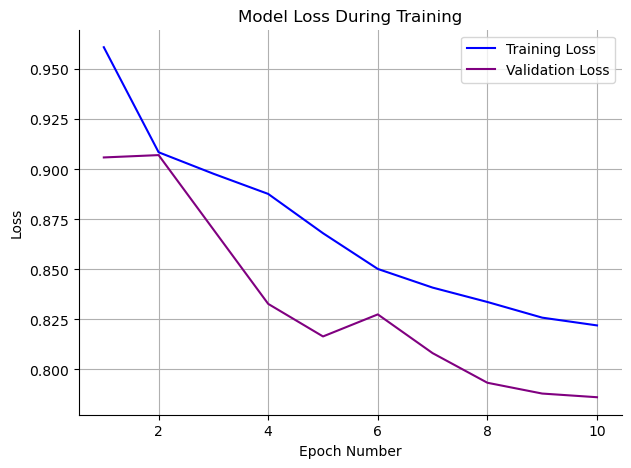

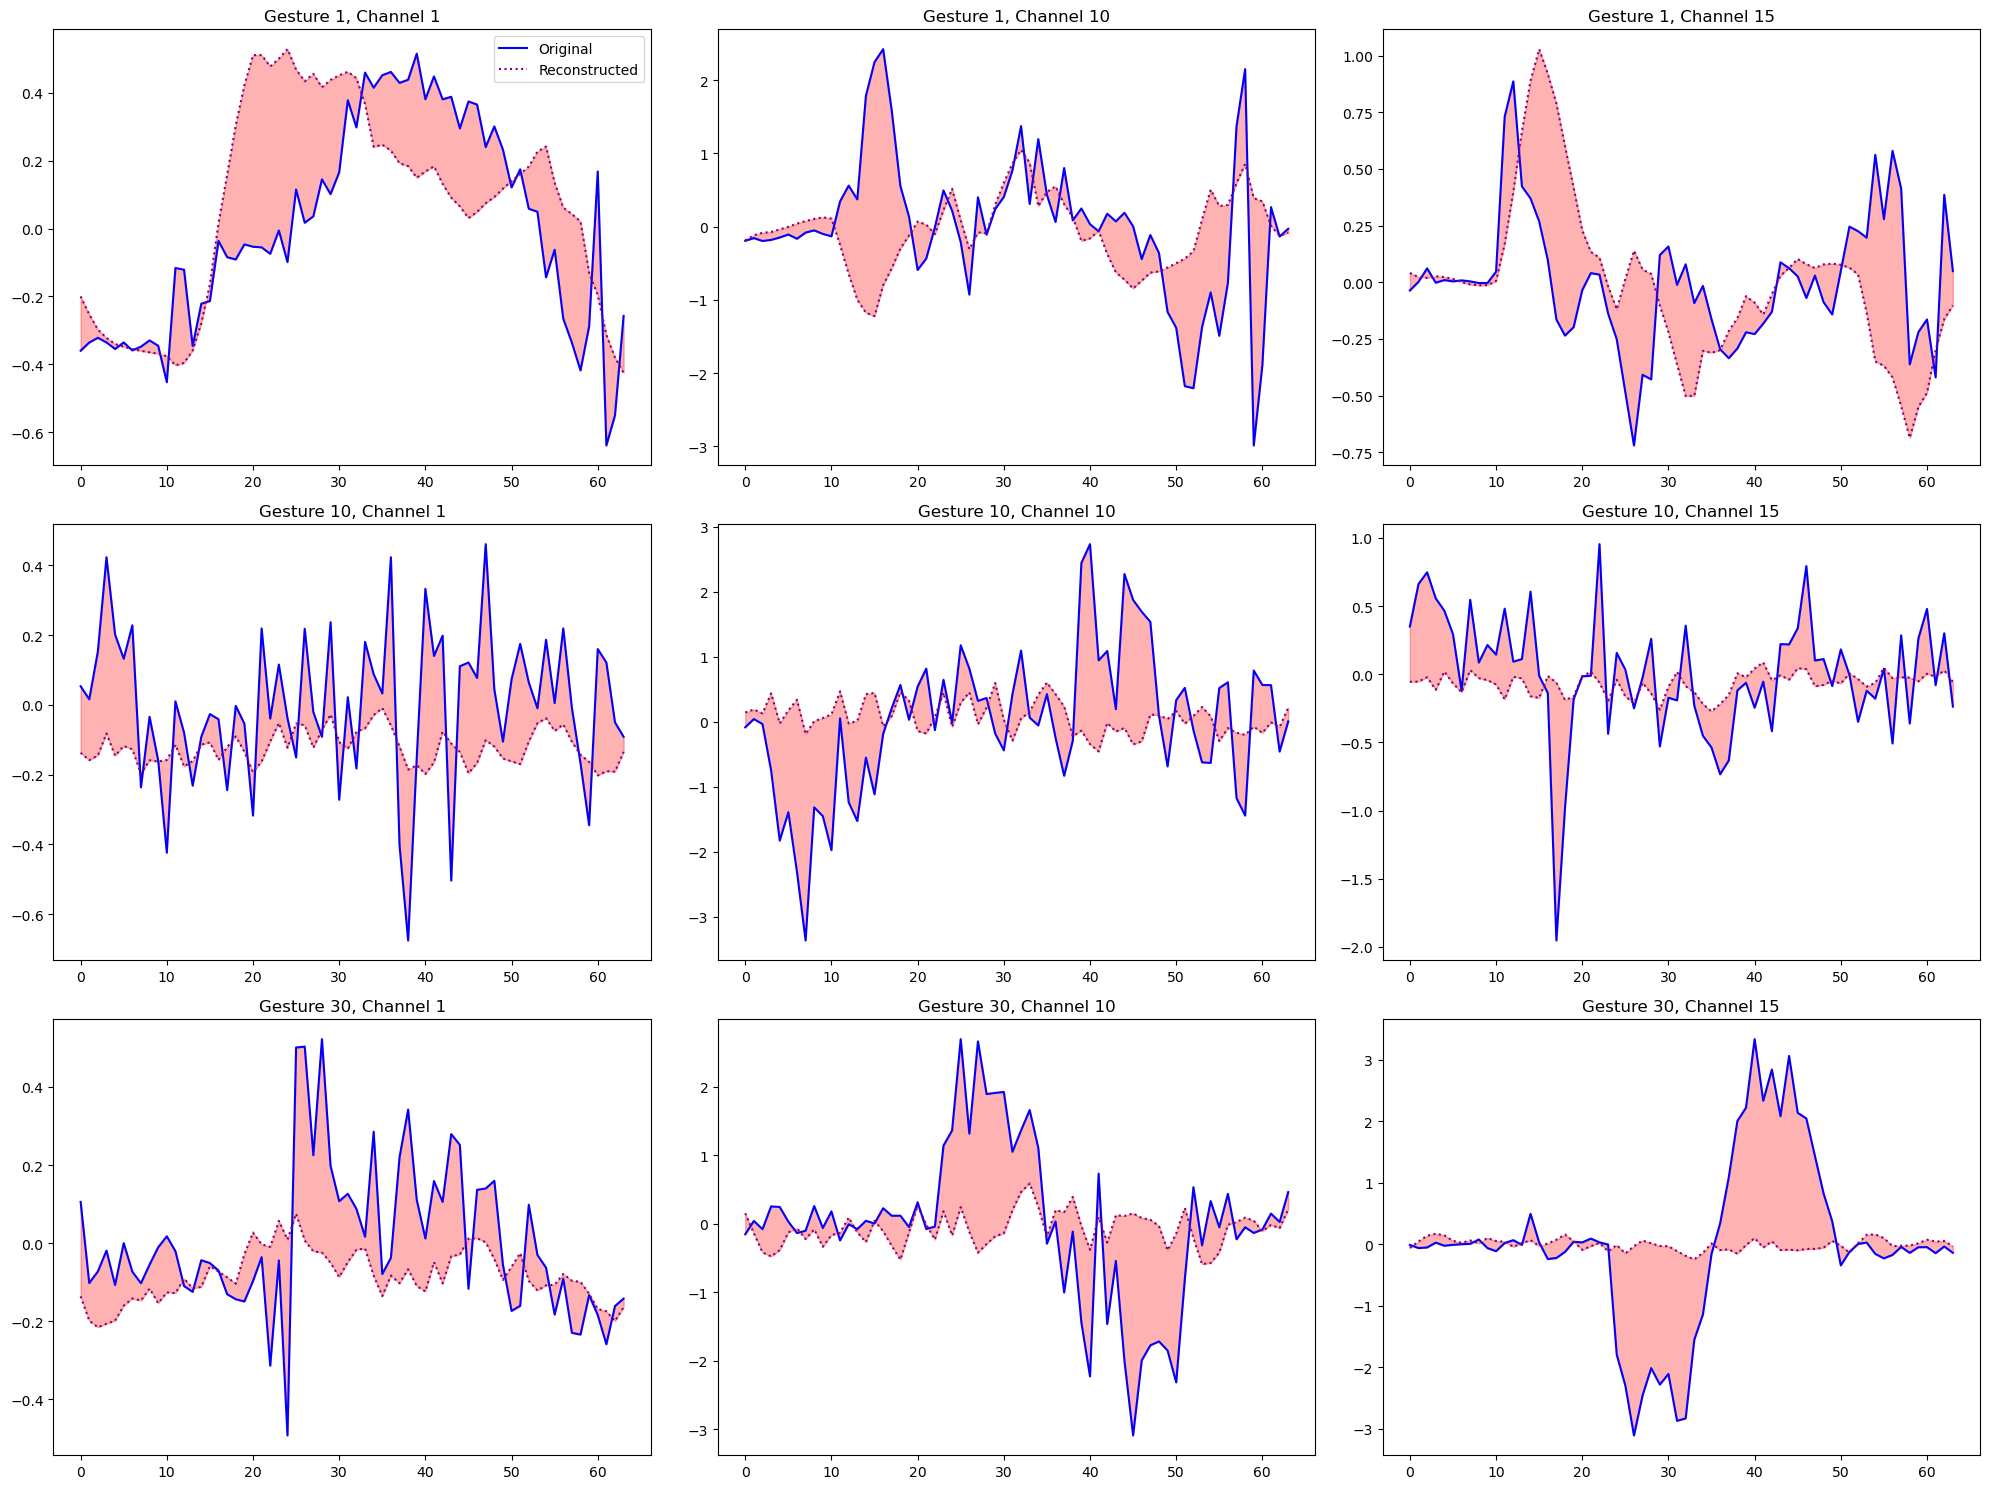

In [20]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [96, 64, 32, 16, 8, 3]

# With mirroring
model_96_64_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_96_64_32_16_8_3mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

Started
Epoch 0: Train Loss: 1.1599685255485246;  Validation Loss: 1.083414765921506
Epoch 1: Train Loss: 1.0711466662491425;  Validation Loss: 1.0286721424622969
Epoch 2: Train Loss: 1.0270596923707407;  Validation Loss: 0.995290379632603
Epoch 3: Train Loss: 0.9985354301295702;  Validation Loss: 0.9639977677301927
Epoch 4: Train Loss: 0.9710825930667829;  Validation Loss: 0.9290252544663169
Epoch 5: Train Loss: 0.9450264633456363;  Validation Loss: 0.8980826572938398
Epoch 6: Train Loss: 0.9259960719301731;  Validation Loss: 0.8759032731706445
Epoch 7: Train Loss: 0.9094052593919295;  Validation Loss: 0.8608493669466539
Epoch 8: Train Loss: 0.8972674819487559;  Validation Loss: 0.8501130803064867
Epoch 9: Train Loss: 0.8900821503204636;  Validation Loss: 0.8417687659913843


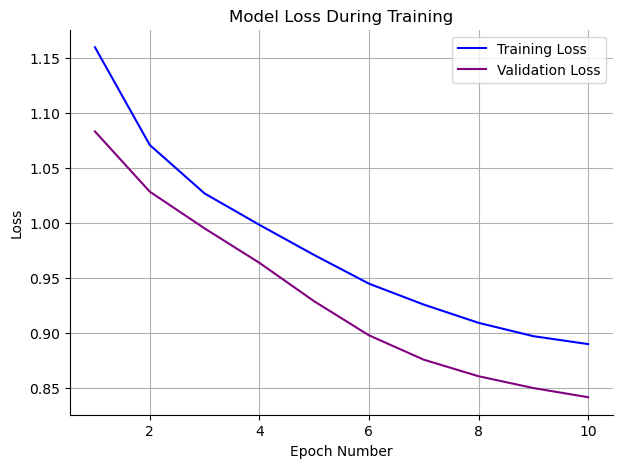

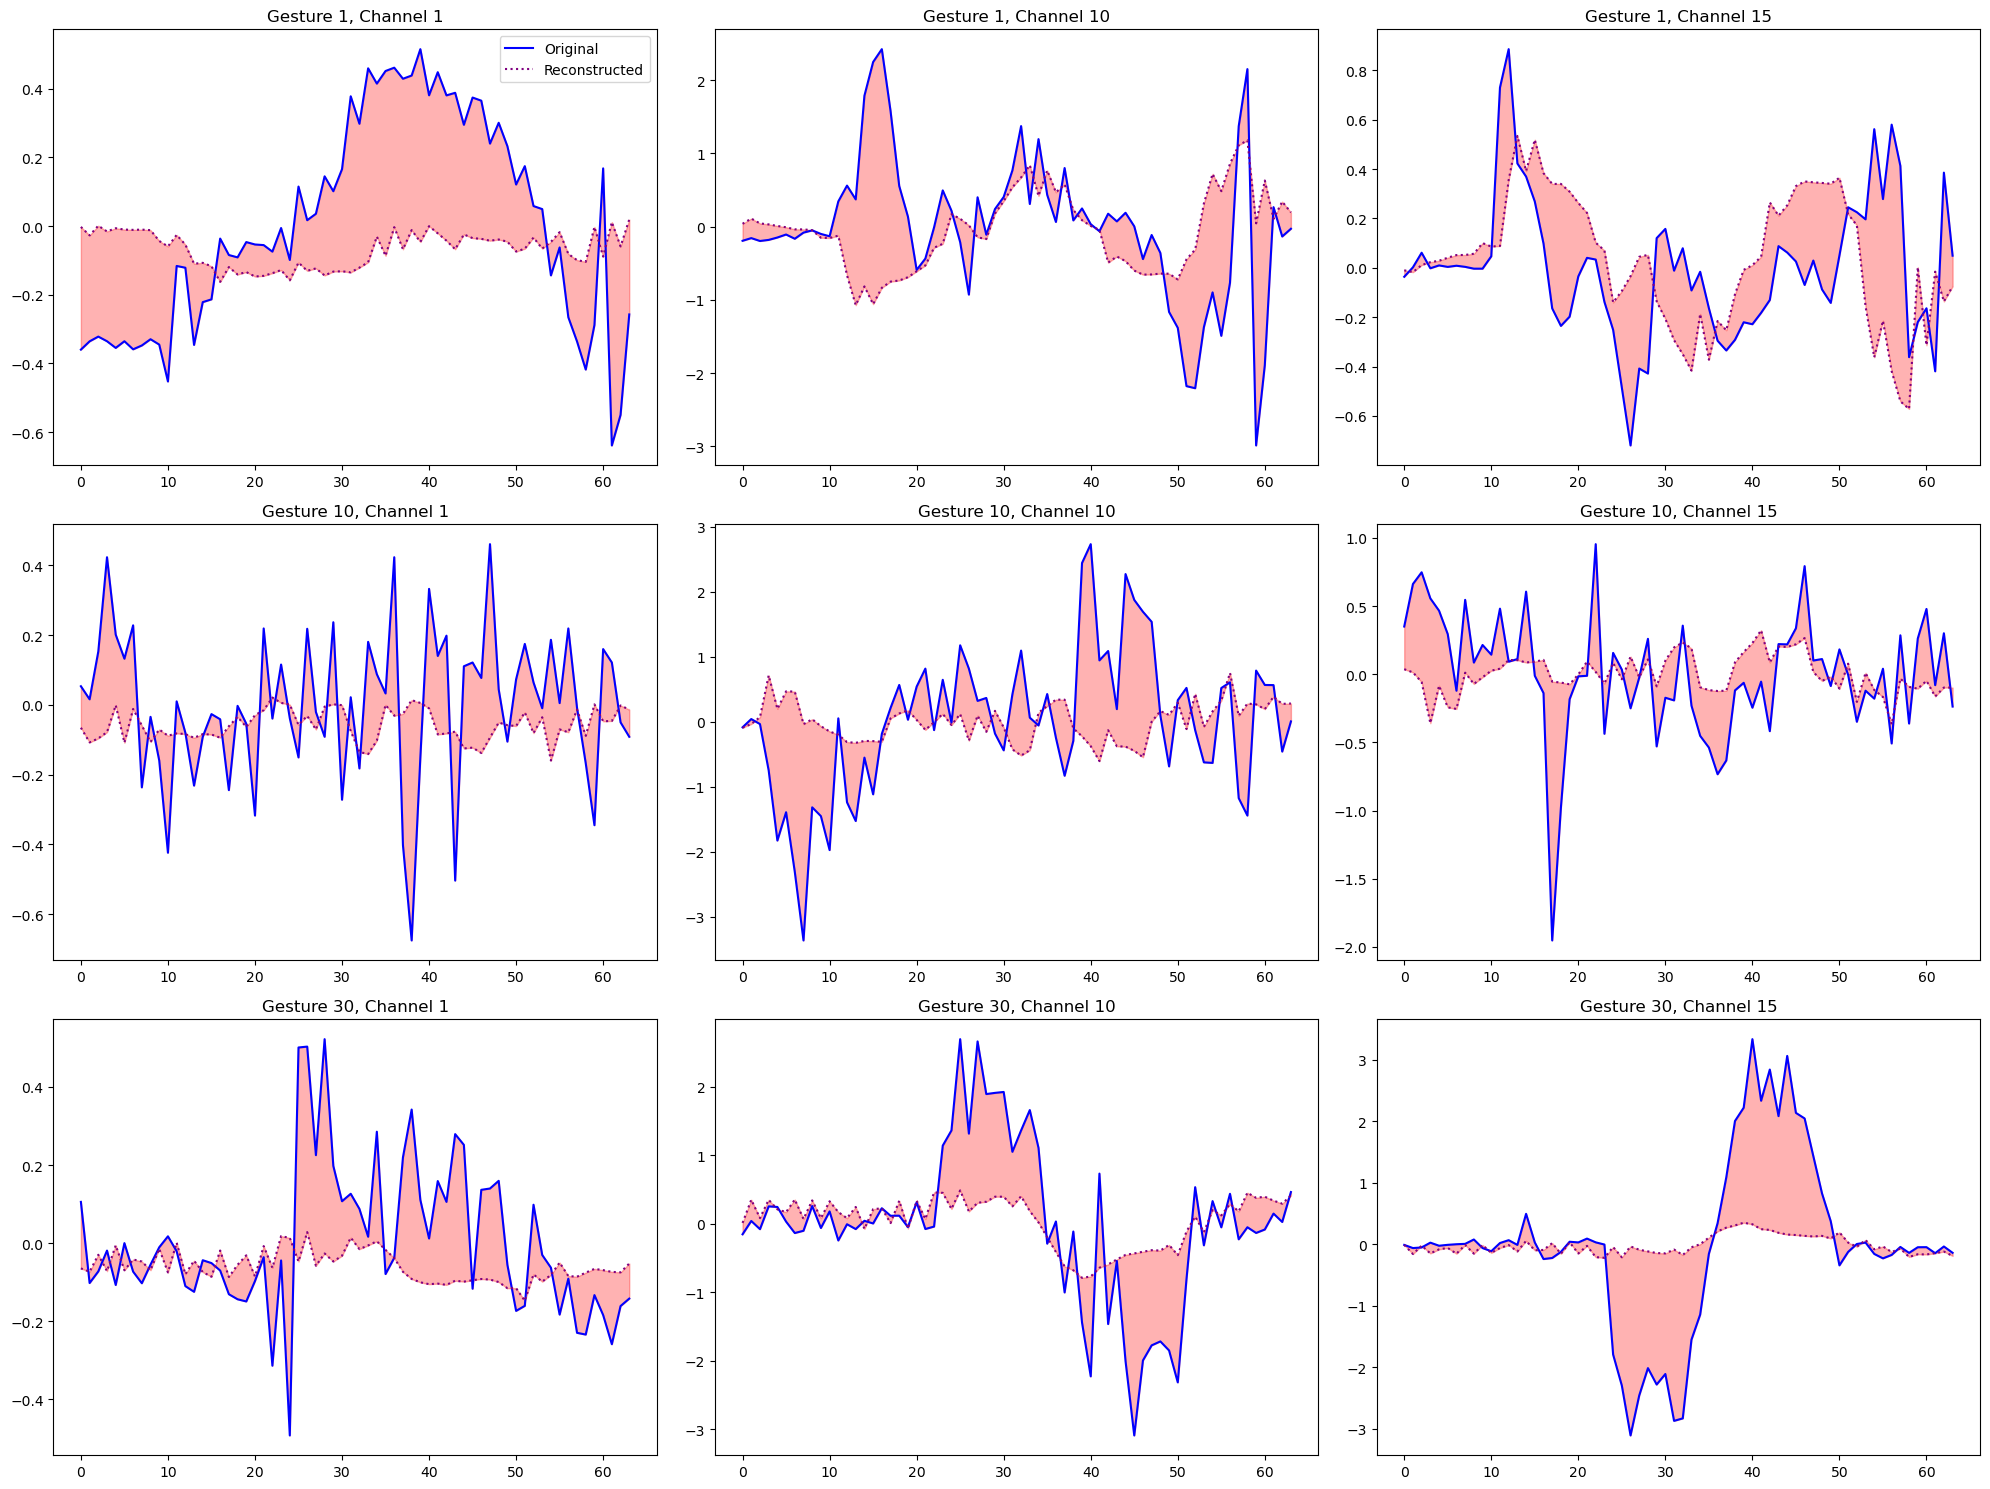

In [21]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [3]

# With mirroring
model_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_3mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

Started
Epoch 0: Train Loss: 0.9723201265817956;  Validation Loss: 0.8906302018599077
Epoch 1: Train Loss: 0.891485095778598;  Validation Loss: 0.83121518926187
Epoch 2: Train Loss: 0.8702030876014806;  Validation Loss: 0.8205405825918372
Epoch 3: Train Loss: 0.8609492197821412;  Validation Loss: 0.8086583804000508
Epoch 4: Train Loss: 0.8552424862414976;  Validation Loss: 0.8013739504597404
Epoch 5: Train Loss: 0.8451288666906236;  Validation Loss: 0.7920681265267459
Epoch 6: Train Loss: 0.8406760028645962;  Validation Loss: 0.7845950533043254
Epoch 7: Train Loss: 0.8328625552261932;  Validation Loss: 0.7802380160851912
Epoch 8: Train Loss: 0.8273800981195667;  Validation Loss: 0.7905970703471791
Epoch 9: Train Loss: 0.8253819814211205;  Validation Loss: 0.7781796902418137


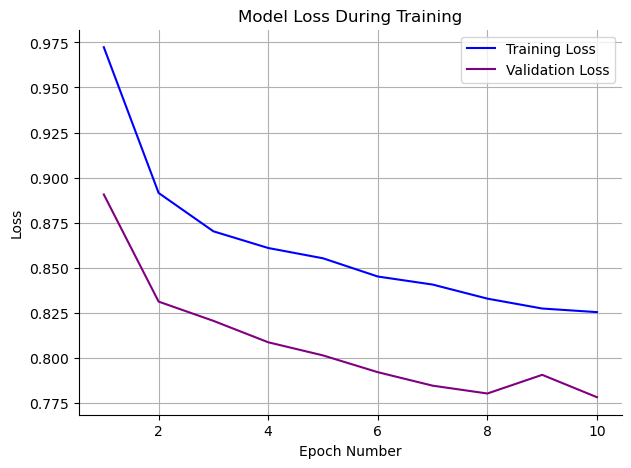

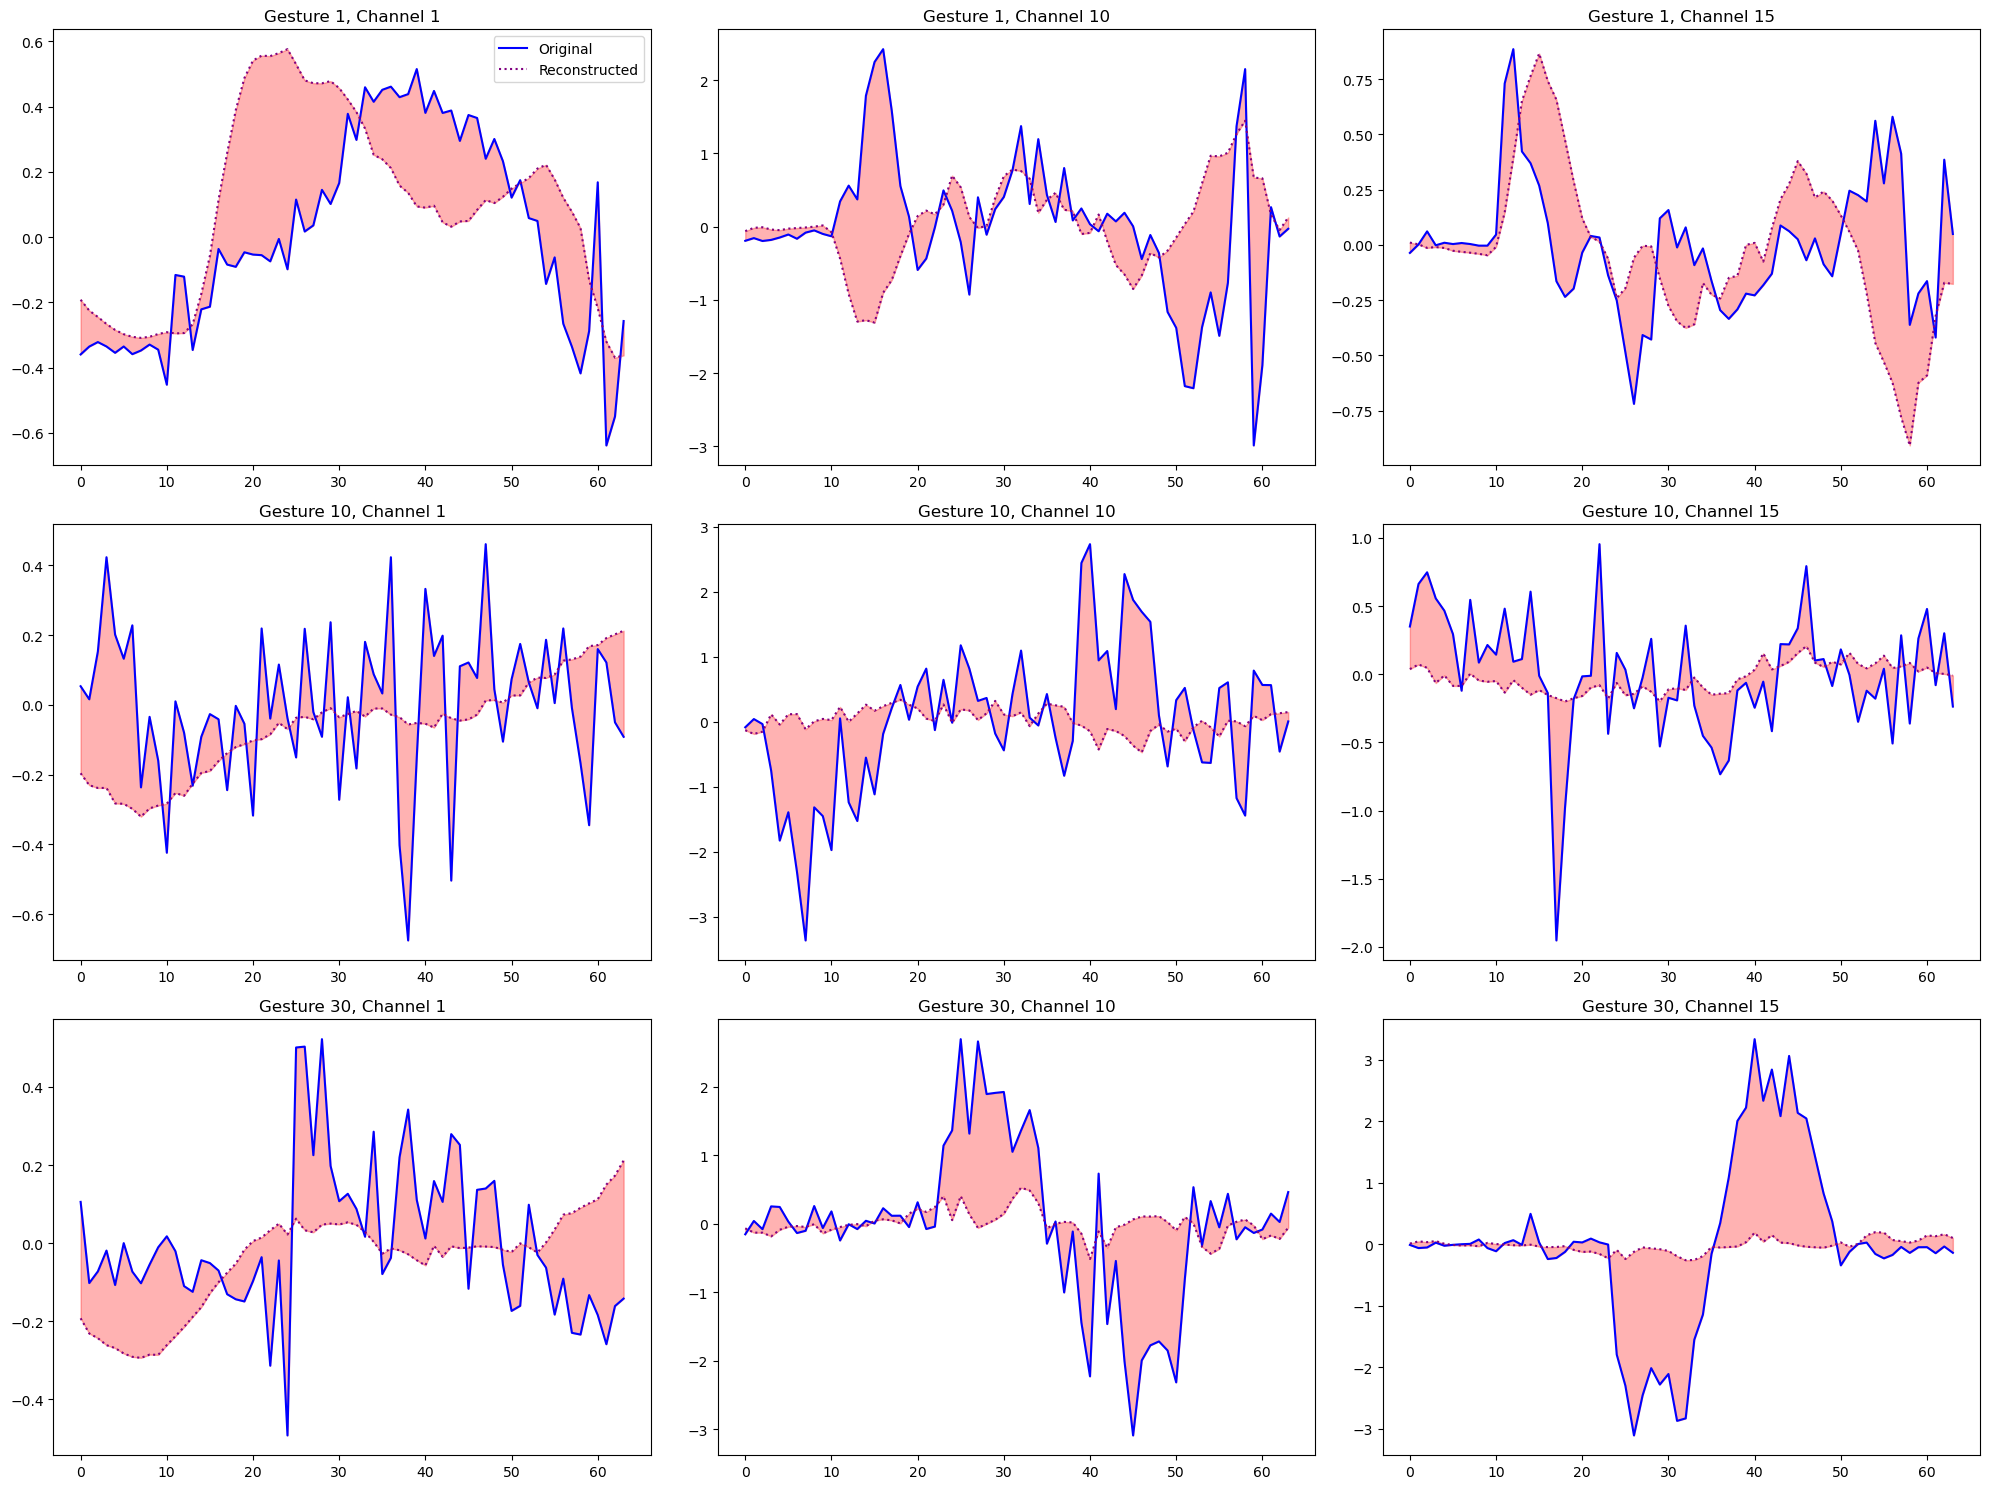

In [22]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [64, 32, 16, 8, 3]

# With mirroring
model_64_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_64_32_16_8_3mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

Started
Epoch 0: Train Loss: 0.9144186234172387;  Validation Loss: 0.8199090144850991
Epoch 1: Train Loss: 0.8541491748411444;  Validation Loss: 0.7975808734243567
Epoch 2: Train Loss: 0.8317483633379393;  Validation Loss: 0.787222523580898
Epoch 3: Train Loss: 0.8134111475340927;  Validation Loss: 0.7564628950574181
Epoch 4: Train Loss: 0.797045609619044;  Validation Loss: 0.7426334822719748
Epoch 5: Train Loss: 0.7864114777951301;  Validation Loss: 0.7308524047786539
Epoch 6: Train Loss: 0.7760853556138051;  Validation Loss: 0.7156834372065284
Epoch 7: Train Loss: 0.765856618368173;  Validation Loss: 0.7053941122510217
Epoch 8: Train Loss: 0.7608647067335588;  Validation Loss: 0.6970043046907946
Epoch 9: Train Loss: 0.7543804751166815;  Validation Loss: 0.6900939711115577


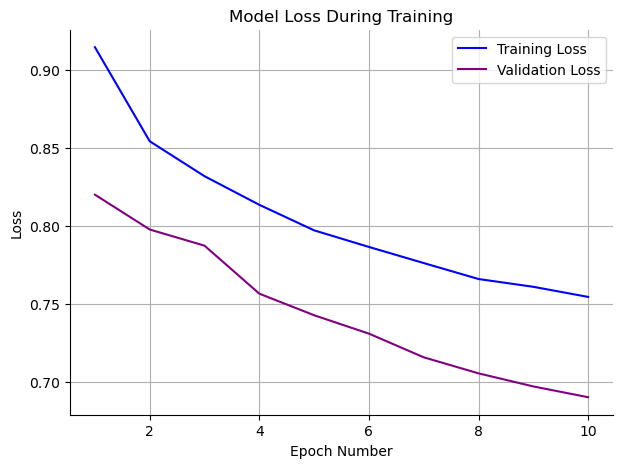

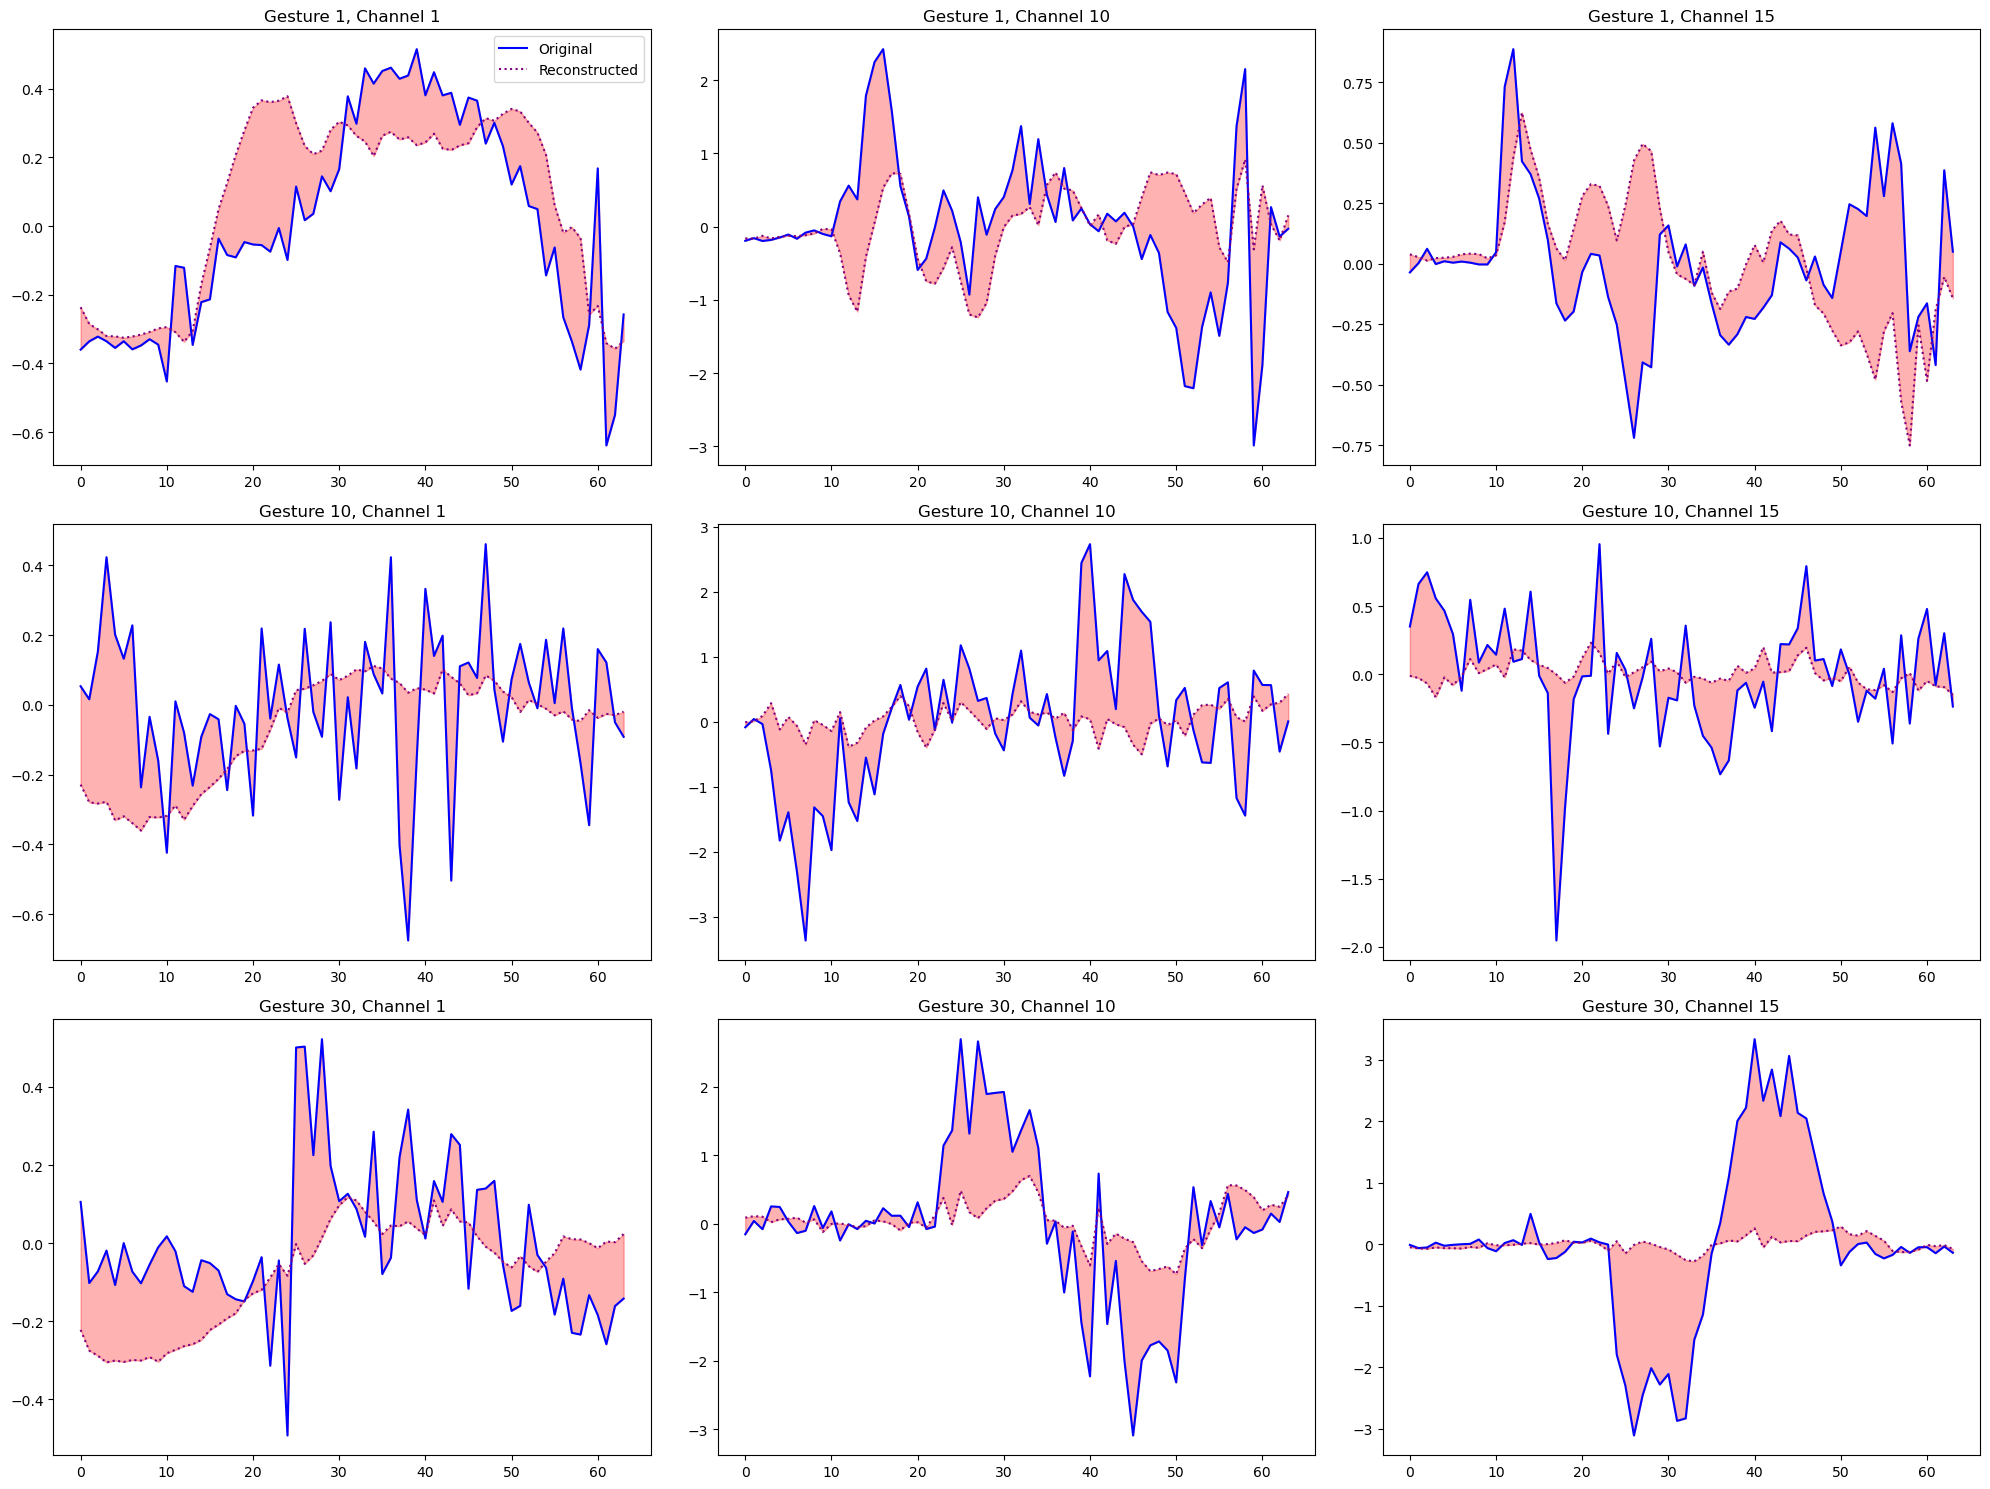

In [23]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [96, 64, 16, 3]

# With mirroring
model_96_64_16_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_96_64_16_3mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

In [24]:
not_saved = False

if not_saved:
    torch.save(model_96_64_16_3mir .state_dict(), model_dir_path+'RNNAE_96_64_16_3mir_dropp25_vallossp70_BothFull.pth')


## Manual Grid Search

Started
Epoch 0: Train Loss: 0.8658902486668357;  Validation Loss: 0.7155590815977617
Epoch 1: Train Loss: 0.7240252924870841;  Validation Loss: 0.6139150370251049
Epoch 2: Train Loss: 0.6606420980224127;  Validation Loss: 0.5739506306973371
Epoch 3: Train Loss: 0.62953055583978;  Validation Loss: 0.5497126050970771
Epoch 4: Train Loss: 0.6032305548462686;  Validation Loss: 0.526447132229805
Epoch 5: Train Loss: 0.5822472308255449;  Validation Loss: 0.49733003025705164
Epoch 6: Train Loss: 0.5644021803819681;  Validation Loss: 0.4768926216797395
Epoch 7: Train Loss: 0.5530301788939705;  Validation Loss: 0.47102891450578516
Epoch 8: Train Loss: 0.546545454972907;  Validation Loss: 0.46306939084421506
Epoch 9: Train Loss: 0.5431885394868972;  Validation Loss: 0.4627802270379933


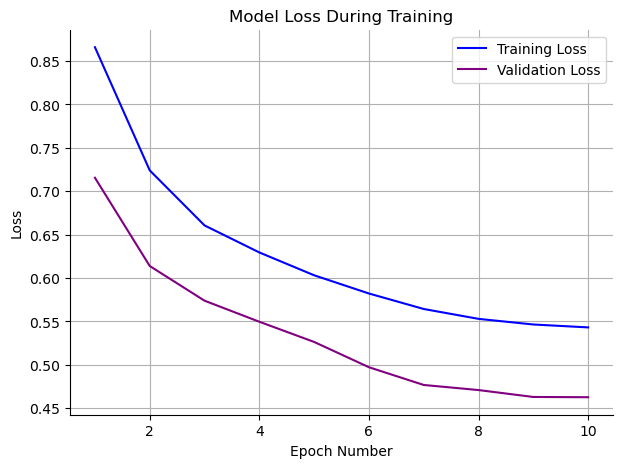

In [6]:
print("Started")

# Hyperparameters and dataset setup
num_layers = 3
lr = 0.001
hidden_dim = 56

# With progressive halving
model_56_nl3_prog, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim, num_layers, train_loader, test_loader, progressive_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.8916518997542465;  Validation Loss: 0.755272778597745
Epoch 1: Train Loss: 0.7584639878212651;  Validation Loss: 0.6780330755493857
Epoch 2: Train Loss: 0.7090004441104357;  Validation Loss: 0.633870845491236
Epoch 3: Train Loss: 0.6752600609501705;  Validation Loss: 0.6025752967054193
Epoch 4: Train Loss: 0.6503925919532776;  Validation Loss: 0.581473164937713
Epoch 5: Train Loss: 0.6374009787281857;  Validation Loss: 0.5659765546972101
Epoch 6: Train Loss: 0.6275168438500995;  Validation Loss: 0.5573685643347827
Epoch 7: Train Loss: 0.6172807737241818;  Validation Loss: 0.5419551445679232
Epoch 8: Train Loss: 0.6050799194770523;  Validation Loss: 0.5314699614589865
Epoch 9: Train Loss: 0.6002279369136955;  Validation Loss: 0.5252167027104985


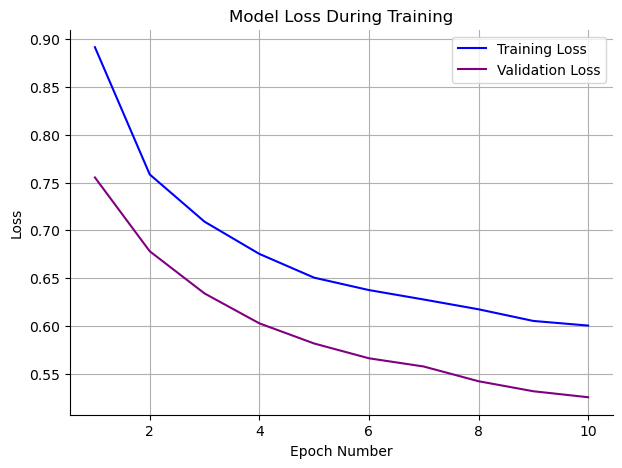

In [7]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [56, 28, 14]

# With mirroring
model_56_28_14mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9824404346792004;  Validation Loss: 0.8837176723913713
Epoch 1: Train Loss: 0.8998397475556482;  Validation Loss: 0.8316085203127428
Epoch 2: Train Loss: 0.8754856254481063;  Validation Loss: 0.816749862649224
Epoch 3: Train Loss: 0.867141937907738;  Validation Loss: 0.8072567636316473
Epoch 4: Train Loss: 0.8591370952280262;  Validation Loss: 0.8018583899194544
Epoch 5: Train Loss: 0.8523717726333232;  Validation Loss: 0.7939892357045953
Epoch 6: Train Loss: 0.8452619963054415;  Validation Loss: 0.7920223718339746
Epoch 7: Train Loss: 0.8391684210753139;  Validation Loss: 0.7833799882368608
Epoch 8: Train Loss: 0.8338033013705966;  Validation Loss: 0.7759107974442568
Epoch 9: Train Loss: 0.8296673622312425;  Validation Loss: 0.7740219303152778


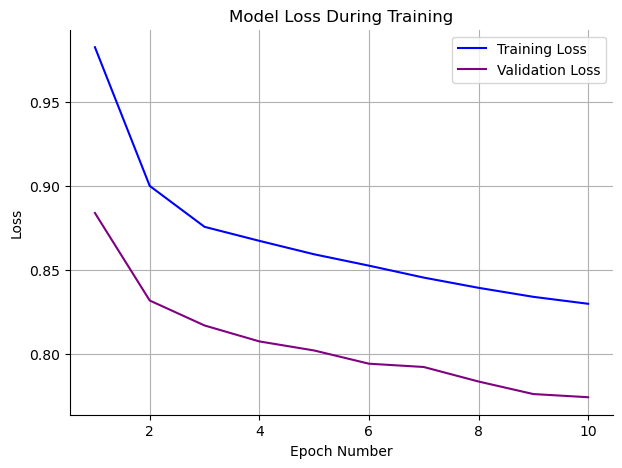

In [8]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [42, 32, 16, 8, 3]
model_42_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9612695552125762;  Validation Loss: 0.8479757146401838
Epoch 1: Train Loss: 0.8809262770640699;  Validation Loss: 0.8202232149514285
Epoch 2: Train Loss: 0.8632323002513451;  Validation Loss: 0.7996616742827676
Epoch 3: Train Loss: 0.8480201884161068;  Validation Loss: 0.7940228175033223
Epoch 4: Train Loss: 0.8391213364238981;  Validation Loss: 0.7790417589924552
Epoch 5: Train Loss: 0.8265523835073544;  Validation Loss: 0.773148703304204
Epoch 6: Train Loss: 0.8174397251274013;  Validation Loss: 0.7672561556100845
Epoch 7: Train Loss: 0.8121437053137188;  Validation Loss: 0.7662340768358924
Epoch 8: Train Loss: 0.8043292662765407;  Validation Loss: 0.7665628045797348
Epoch 9: Train Loss: 0.8001347840586795;  Validation Loss: 0.7536590437997471


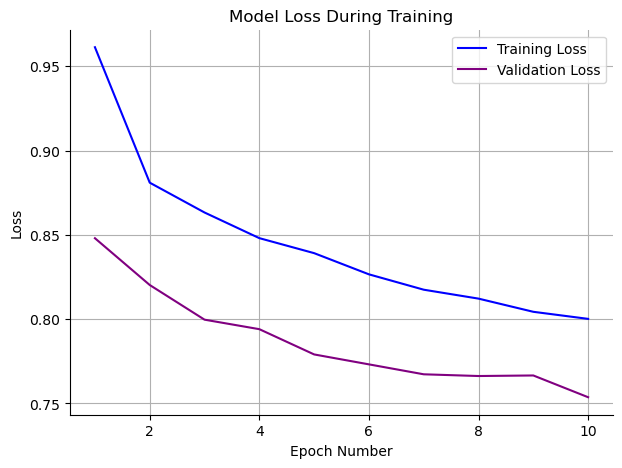

In [9]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [100, 32, 16, 8, 3]
model_100_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9523155674149718;  Validation Loss: 0.8327158852057024
Epoch 1: Train Loss: 0.8583318591117859;  Validation Loss: 0.7888086600737139
Epoch 2: Train Loss: 0.8361366164835193;  Validation Loss: 0.7760321226986971
Epoch 3: Train Loss: 0.8129218303704564;  Validation Loss: 0.7613771097226576
Epoch 4: Train Loss: 0.7970705983004992;  Validation Loss: 0.7505743950605392
Epoch 5: Train Loss: 0.7865764626973792;  Validation Loss: 0.7440010607242584
Epoch 6: Train Loss: 0.7777635915369927;  Validation Loss: 0.7362977862358093
Epoch 7: Train Loss: 0.7732437856589691;  Validation Loss: 0.7287649661302567
Epoch 8: Train Loss: 0.7680197161964223;  Validation Loss: 0.7184210324829275
Epoch 9: Train Loss: 0.7637476717369466;  Validation Loss: 0.7065966332500632


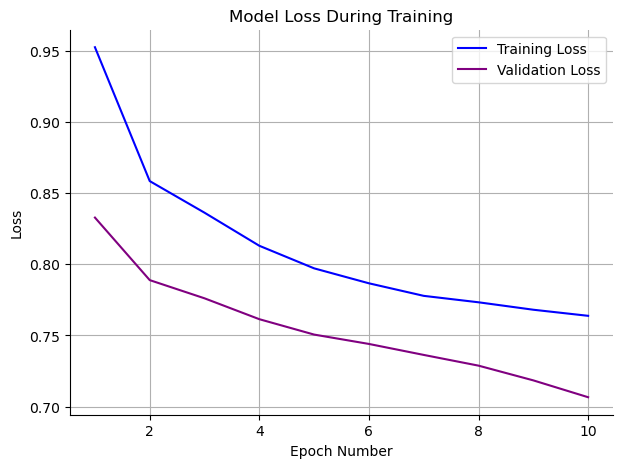

In [10]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [56, 28, 3]
model_56_28_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.7119742575325544;  Validation Loss: 0.47809473357417365
Epoch 1: Train Loss: 0.43778709331645244;  Validation Loss: 0.3400531702420928
Epoch 2: Train Loss: 0.35856201339371596;  Validation Loss: 0.2762899205765941
Epoch 3: Train Loss: 0.32260048615781567;  Validation Loss: 0.24243313277309592
Epoch 4: Train Loss: 0.30040964635112616;  Validation Loss: 0.22126874361525883
Epoch 5: Train Loss: 0.28624895196172256;  Validation Loss: 0.2075149267911911
Epoch 6: Train Loss: 0.27781233512148074;  Validation Loss: 0.19722823730923913
Epoch 7: Train Loss: 0.27031459763080257;  Validation Loss: 0.18981764973564583
Epoch 8: Train Loss: 0.26519570169569573;  Validation Loss: 0.18429042551327834
Epoch 9: Train Loss: 0.260040207376963;  Validation Loss: 0.17911444079469552


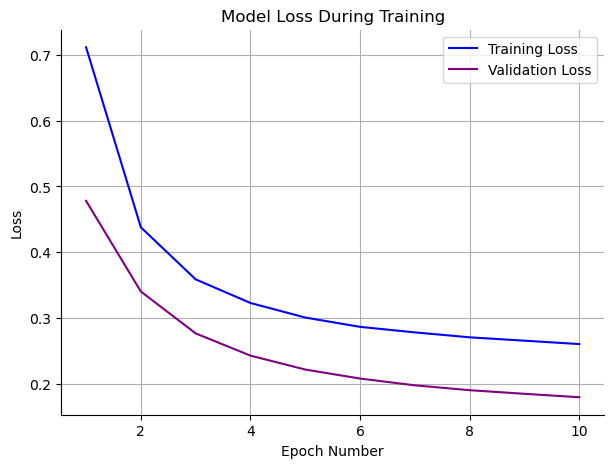

In [11]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64]
model_64mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.7913583396356317;  Validation Loss: 0.6001017432321202
Epoch 1: Train Loss: 0.5849117689494845;  Validation Loss: 0.48346831039948895
Epoch 2: Train Loss: 0.5064727154713643;  Validation Loss: 0.4257187321782112
Epoch 3: Train Loss: 0.4688040885744216;  Validation Loss: 0.3889031064781276
Epoch 4: Train Loss: 0.4409818739830693;  Validation Loss: 0.3615294742313298
Epoch 5: Train Loss: 0.42394808877872514;  Validation Loss: 0.3442778932777318
Epoch 6: Train Loss: 0.41517289869392976;  Validation Loss: 0.3347460146654736
Epoch 7: Train Loss: 0.4056298544135275;  Validation Loss: 0.3226108324121345
Epoch 8: Train Loss: 0.39959620637229726;  Validation Loss: 0.3191756568849087
Epoch 9: Train Loss: 0.3956873288637475;  Validation Loss: 0.3147685910490426


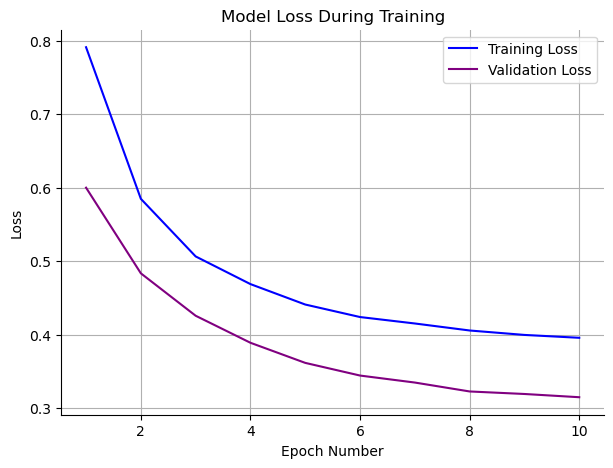

In [12]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 40]
model_64_40, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.8411485228357436;  Validation Loss: 0.658314898610115
Epoch 1: Train Loss: 0.6632092896896072;  Validation Loss: 0.5680929476564581
Epoch 2: Train Loss: 0.6094017949285386;  Validation Loss: 0.523263163187287
Epoch 3: Train Loss: 0.5702757593951647;  Validation Loss: 0.4835506609895013
Epoch 4: Train Loss: 0.5441493222230598;  Validation Loss: 0.4650081992149353
Epoch 5: Train Loss: 0.5312584989433047;  Validation Loss: 0.45182127302343195
Epoch 6: Train Loss: 0.5208764902398556;  Validation Loss: 0.4390872994607145
Epoch 7: Train Loss: 0.5142961672589749;  Validation Loss: 0.4321774941953746
Epoch 8: Train Loss: 0.5104767917832241;  Validation Loss: 0.429717402566563
Epoch 9: Train Loss: 0.505420296629773;  Validation Loss: 0.4244903779842637


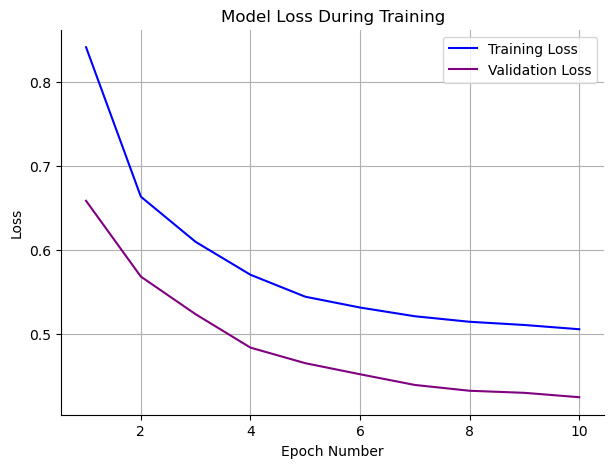

In [13]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 40, 32]
model_64_40_32mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.864165874976146;  Validation Loss: 0.6929543384096839
Epoch 1: Train Loss: 0.677916679955736;  Validation Loss: 0.579387525265867
Epoch 2: Train Loss: 0.6161991184270834;  Validation Loss: 0.5366670069369402
Epoch 3: Train Loss: 0.5824915163124664;  Validation Loss: 0.5035544417121194
Epoch 4: Train Loss: 0.5545866455458388;  Validation Loss: 0.47079728001897986
Epoch 5: Train Loss: 0.5322676893276505;  Validation Loss: 0.4549604925242337
Epoch 6: Train Loss: 0.5195670173138003;  Validation Loss: 0.4433032274246216
Epoch 7: Train Loss: 0.5079265640506262;  Validation Loss: 0.4357206306674264
Epoch 8: Train Loss: 0.5020452466192125;  Validation Loss: 0.42927277223630383
Epoch 9: Train Loss: 0.4972510756571082;  Validation Loss: 0.42416490478949115


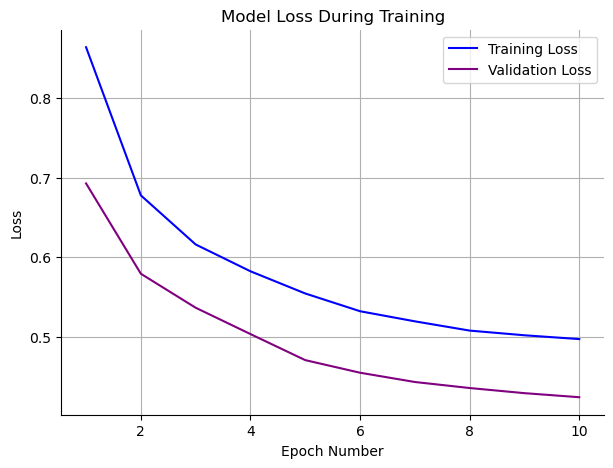

In [14]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [44, 22]
model_44_22mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.8382476794568798;  Validation Loss: 0.6584815680980682
Epoch 1: Train Loss: 0.6532627947722809;  Validation Loss: 0.553615305911411
Epoch 2: Train Loss: 0.5762340471714358;  Validation Loss: 0.4872644245624542
Epoch 3: Train Loss: 0.5310091753549213;  Validation Loss: 0.4589115354147824
Epoch 4: Train Loss: 0.504808182203317;  Validation Loss: 0.4384138272567229
Epoch 5: Train Loss: 0.4879307950599284;  Validation Loss: 0.424044823104685
Epoch 6: Train Loss: 0.4800378970707519;  Validation Loss: 0.4153056246313182
Epoch 7: Train Loss: 0.4724958474877514;  Validation Loss: 0.40860723500902
Epoch 8: Train Loss: 0.46716565459589415;  Validation Loss: 0.4010275060480291
Epoch 9: Train Loss: 0.46348240481147285;  Validation Loss: 0.3948701247572899


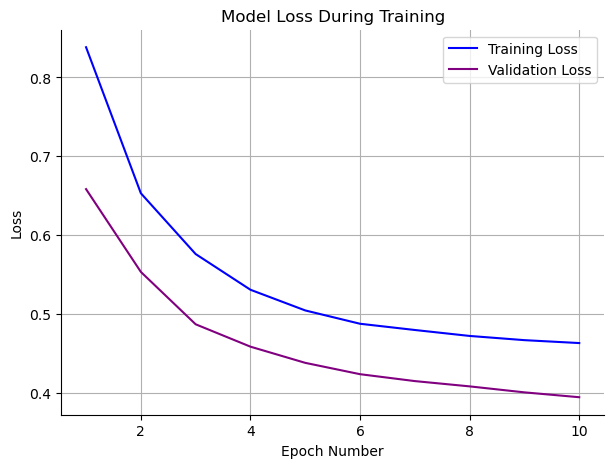

In [15]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 22]
model_64_22mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.8189354976521263;  Validation Loss: 0.6416699358008124
Epoch 1: Train Loss: 0.6526798854900312;  Validation Loss: 0.553256859833544
Epoch 2: Train Loss: 0.6016145212740838;  Validation Loss: 0.5141063169999556
Epoch 3: Train Loss: 0.5678613012350058;  Validation Loss: 0.48204268447377463
Epoch 4: Train Loss: 0.5407813579975804;  Validation Loss: 0.4682869362560185
Epoch 5: Train Loss: 0.5268831735924829;  Validation Loss: 0.4537688121199608
Epoch 6: Train Loss: 0.5139315845091131;  Validation Loss: 0.44296868484128604
Epoch 7: Train Loss: 0.503197628108761;  Validation Loss: 0.4371644448150288
Epoch 8: Train Loss: 0.4971657716020753;  Validation Loss: 0.4316831556233493
Epoch 9: Train Loss: 0.49166348312474506;  Validation Loss: 0.4297212199731307


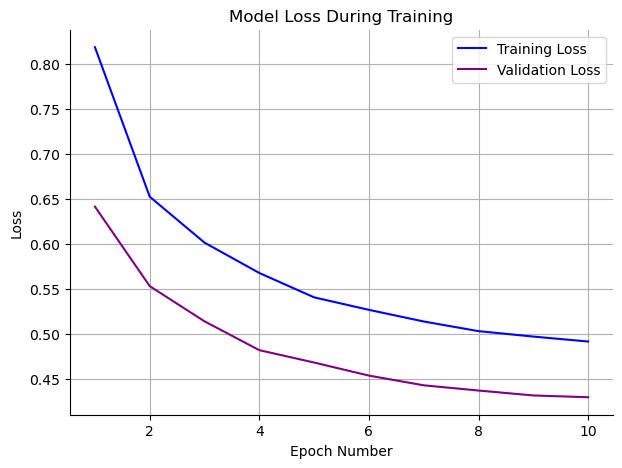

In [16]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [96, 48, 22]
model_96_48_22mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

In [17]:
assert(False)

AssertionError: 

Save a few of the above models

In [ ]:
torch.save(model_56_28_3mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_56_28_3mir_vallossp662_BothFull.pth')
torch.save(model_64_22mir.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_64_22mir_vallossp262_BothFull.pth')
